Load all the necessary libraries:

In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

Start off by defining some conversion functions. Each is designed to reduce the file size a bit by converting text data into only a few bits worth of numerical data.

The the data being loaded is straight from Kaggle (except the Projects.csv set, which had to be treated separately due to it's size). If you are working with files ending with `_clean` these steps are irrelevant beyond discovering how the cleaned files were created.

In [ ]:
# If the value is "Yes", convert to a 1. Otherwise, 0 (i.e "No")

def yes_no_binary_converter(x):
    return 1 if x == "Yes" else 0

def zipcode_converter(x):
    try:
        return int(x)
    except ValueError:
        return np.nan

# For Schools.csv
def metro_type_converter(x):
    if x == 'rural':
        return 1
    if x == 'suburban':
        return 2
    if x == 'urban':
        return 3
    if x == 'town':
        return 4
    
    return 0 # if metropolitan type is ambiguous

# For Teachers.csv
def teacher_prefix_converter(x):
    if x == 'Mrs.':
        return 1
    if x == 'Mr.':
        return 2
    
    return 0 # if prefix is ambiguous

# For Projects.csv
def grade_level_converter(x):
    if '2' in x:
        return 1
    if '3' in x:
        return 2
    if '6' in x:
        return 3
    if '9' in x:
        return 4
        
    return -1 # if grade is unknown/missing

# For Projects.csv
def project_type_converter(x):
    if x == 'Professional Development':
        return 0
    if x == 'Student-Led':
        return 1
    if x == 'Teacher-Led':
        return 2
    
# For Projects.csv
def project_status_converter(x):
    if x == 'Expired':
        return 0
    if x == 'Fully Funded':
        return 1
    if x == 'Live':
        return 2

Load *Donors.csv*. Modify headers to exclude spaces. Binary conversion for whether the donor is a teacher. Ensure zip code is of integer type. Clean state column by ensuring that unmarked states are corrected based on city and zip information with a 95% confidence level

In [ ]:
donors_dat = pd.read_csv('data/Donors.csv',
                         header=0,
                         names=['donor_id', 'donor_city', 'donor_state', 'donor_teacher', 'donor_zip'],
                         na_values='other',
                         converters={'donor_zip': zipcode_converter, 'donor_teacher': yes_no_binary_converter})

In [ ]:
donors_dat.to_csv('data/data_clean/donors_clean.csv')

In [ ]:
# donor_state_null = donors_dat[(donors_dat['donor_state'].isnull()) & (donors_dat['donor_city'].notnull()) & (donors_dat['donor_zip'].notnull())]

In [ ]:
# replacements = []

# unique_donor_locals = donor_state_null.drop_duplicates(['donor_city', 'donor_zip'])

# c = 0
# l = len(unique_donor_locals)
# from datetime import datetime
# s = datetime.now()

# for row in unique_donor_locals.itertuples():
#     donor_augment = donors_dat[(donors_dat['donor_city'] == row.donor_city) & (donors_dat['donor_zip'] == row.donor_zip) & 
#               (donors_dat['donor_state'].notnull())]
#     if len(donor_augment) > 1:
#         top_approxs, top_approxs_cnt = np.unique(donor_augment['donor_state'], return_counts=True)
#         m = top_approxs_cnt.argmax()
#         if max(top_approxs_cnt) / sum(top_approxs_cnt) > 0.95:
#             replacements.append([row.donor_id, top_approxs[m]])
#     c += 1
#     if c % 50 == 0:
#         print('{:.1f}%...\t Remaining: {}'.format(c/l, (datetime.now() - s)/c))
#         break
        
# replacements

Load *Donations.csv*. Modify headers to exclude spaces. Binary conversion for whether the donation included an optional donation. Ensure timestamps are converted to integers (for easy computation of timedeltas and reverse-conversion).

In [ ]:
donations_dat = pd.read_csv('data/Donations.csv',
                         header=0,
                         names=['project_id', 'donation_id', 'donor_id', 'opt_donation', 'amount', 'cart_seq', 'date'],
                         converters={'opt_donation': yes_no_binary_converter},
                         parse_dates=['date'])

donations_dat['date'] = donations_dat['date'].apply(lambda t: int(t.timestamp()))
donations_dat.sample(5) # randomly sample 5

Load *Schools.csv*. Modify headers to exclude spaces. Conversion of metro type to numerical.

In [ ]:
schools_dat = pd.read_csv('data/Schools.csv',
                         header=0,
                         names=['school_id', 'school_name', 'metro_type', 'free_lunch', 'school_state', 'school_zip', 'school_city', 'school_county', 'school_district'],
                         converters={'metro_type': metro_type_converter})
schools_dat.sample(5) # randomly sample 5

Load *Teachers.csv*. Modify headers to exclude spaces. Conversion of teacher prefix to numerical. Dates to integer (see above).

In [ ]:
teachers_dat = pd.read_csv('data/Teachers.csv',
                           header=0,
                           names=['teacher_id', 'prefix', 'first_project_posted'],
                           parse_dates=['first_project_posted'],
                           converters={'prefix': teacher_prefix_converter})

teachers_dat['first_project_posted'] = teachers_dat['first_project_posted'].apply(lambda t: int(t.timestamp()))
teachers_dat.sample(5) # randomly sample 5

Load *Resources.csv*. Modify headers to exclude spaces. Remove any rows without `quantity` or `price`, two key variables of the dataset.

In [ ]:
resources_dat = pd.read_csv('data/Resources.csv',
                           header=0,
                           names=['project_id', 'resource', 'quantity', 'price', 'vendor'])

resources_dat = resources_dat.dropna(axis=0, subset=['quantity', 'price'])
resources_dat.sample(5) # randomly sample 5

Load two partitions of *Projects.csv* (previously split, code not included here). Conversion of text to integer (see above). Date values either remain null or are converted to integer (see above).

In [ ]:
# LARGE FILE!
projects_textonly_dat = pd.read_csv('data/Projects_textonly.csv', index_col=0)
projects_textonly_dat.sample(5) # randomly sample 5

In [ ]:
# LARGE FILE!
projects_notext_dat = pd.read_csv('data/Projects_notext.csv', parse_dates=['posted', 'expire', 'funded'],
                                 converters={'proj_type': project_type_converter,
                                             'grade_level': grade_level_converter,
                                             'status': project_status_converter})

projects_notext_dat['posted'] = projects_notext_dat['posted'].apply(lambda t: np.nan if pd.isnull(t) else int(t.timestamp()))
projects_notext_dat['expire'] = projects_notext_dat['expire'].apply(lambda t: np.nan if pd.isnull(t) else int(t.timestamp()))
projects_notext_dat['funded'] = projects_notext_dat['funded'].apply(lambda t: np.nan if pd.isnull(t) else int(t.timestamp()))
projects_notext_dat.sample(5) # randomly sample 5

# Reload

In [2]:
donors_dat = pd.read_csv('data/data_clean/donors_clean.csv')
donations_dat = pd.read_csv('data/data_clean/donations_clean.csv')
schools_dat = pd.read_csv('data/data_clean/schools_clean.csv')
teachers_dat = pd.read_csv('data/data_clean/teachers_clean.csv')
resources_dat = pd.read_csv('data/data_clean/resources_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv')

# Dataset Subsetting

From the last year of donation data: 9 May 2017 - 9 May 2018

Format: `(% of original dataset, # of total entries)`

In [3]:
last_years_donations = Timestamp(donations_dat['date'].max(), unit='s') - pd.DateOffset(years=1)

#timestamp (sec) of one year prior to most recent donation
last_years_donations_sec = int(last_years_donations.timestamp()) 

In [4]:
donations_subset = donations_dat[donations_dat['date'] > last_years_donations_sec]
unique_donations_subset = donations_subset.drop_duplicates('donor_id')
len(donations_subset) / len(donations_dat), len(donations_subset)

(0.2662655475263466, 1248222)

In [5]:
donors_subset = donors_dat[donors_dat['donor_id'].isin(unique_donations_subset['donor_id'])]
len(donors_subset) / len(donors_dat), len(donors_subset)

(0.2764618588173218, 586829)

In [6]:
projects_subset = projects_notext_dat[projects_notext_dat['project_id'].isin(donations_subset['project_id'])]
len(projects_subset) / len(projects_notext_dat), len(projects_subset)

(0.2117445104069809, 222030)

In [7]:
teachers_subset = teachers_dat[teachers_dat['teacher_id'].isin(projects_subset['teacher_id'])]
len(teachers_subset) / len(teachers_dat), len(teachers_subset)

(0.3014296351451973, 121446)

In [8]:
schools_subset = schools_dat[schools_dat['school_id'].isin(projects_subset['school_id'])]
len(schools_subset) / len(schools_dat), len(schools_subset)

(0.5803570205362159, 42362)

In [9]:
resources_subset = resources_dat[resources_dat['project_id'].isin(projects_subset['project_id'])]
len(resources_subset) / len(resources_dat), len(resources_subset)

(0.19849332102815756, 1426400)

# Donors: Who are they?

The goal is to garner the most donations. So, who should our emails be targeting?

In [10]:
unique_donors = donations_subset.groupby('donor_id')
donors_donation_counts = pd.DataFrame({'total_amount': unique_donors['amount'].sum(), 'count': unique_donors['amount'].count()})
donors_donation_counts['avg'] = donors_donation_counts['total_amount'] / donors_donation_counts['count']
donors_donation_counts.sample(5)

,count,total_amount,avg
donor_id,,,
fa363972dcf7f3c79a4922a99ec8acaf,1,25.0,25.0
d2a7308bf1df771c9b61289a19583f60,1,25.0,25.0
6951514de49c9938feb165acc21b22ab,1,25.0,25.0
ed2e59a8e5585153448b7b1efbbb67ca,1,20.0,20.0
81b32e376f406b3abdd9aad6d1eec590,1,25.0,25.0


### How much do people donate?

How does donation frequency compare to donation amounts? Use custom bins.

In [11]:
donate_freq_bins = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50, 100, 200, 500, 1000, 5000, 10000])

In [12]:
donors_donation_counts['bin'] = np.digitize(donors_donation_counts['count'], donate_freq_bins, right=True)
donation_freq = np.unique(donors_donation_counts['bin'], return_counts=True)

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


'24.65% with 2+ donations'

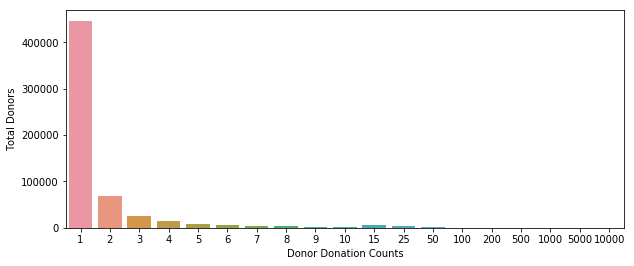

In [16]:
plt.subplots(figsize=(10, 4))
sns.barplot(x=donate_freq_bins, y=donation_freq[1])
plt.xlabel('Donor Donation Counts')
plt.ylabel('Total Donors')
t = sum(donation_freq[1])
'{:.2f}% with 2+ donations'.format(100 * (t - donation_freq[1][0]) / t)

In [18]:
print('Descending Average Donation')
print(donors_donation_counts.sort_values('avg', ascending=False)[:10])
print('Mean/median: {}/{}'.format(round(np.mean(donors_donation_counts['avg'])), round(np.median(donors_donation_counts['avg']))))

print('\nDescending Donations Total Amount')
print(donors_donation_counts.sort_values('total_amount', ascending=False)[:10])
print('Mean/median: {}/{}'.format(round(np.mean(donors_donation_counts['total_amount'])), round(np.median(donors_donation_counts['total_amount']))))

print('\nDescending Donation Count')
print(donors_donation_counts.sort_values('count', ascending=False)[:10])
print('Mean/median: {}/{}'.format(round(np.mean(donors_donation_counts['count'])), round(np.median(donors_donation_counts['count']))))

Descending Average Donation
                                  count  total_amount        avg  bin
donor_id                                                             
b51a1b79ce091021e909fde33c5e5810      1      25000.00  25000.000    0
0c796f4db2c7adc93db6969153616cdc      4      47764.00  11941.000    3
47e50d951a655979e520f8e5e01a7212      1      10000.00  10000.000    0
ebb56c8b81859e95c817c941377a98f1      1       9990.24   9990.240    0
345470c95caa44fd8c5c129075367669      1       7890.48   7890.480    0
1185f4869739d6484525e074c58e5dee      1       7277.26   7277.260    0
7779c0b3af936b7f8f6953f06882c094      6      38255.37   6375.895    5
db1ea4fc95f8d657958a178029a8a203      1       6000.00   6000.000    0
32bbf59291ea50ff7ea998661efbc281      1       6000.00   6000.000    0
28c9d442944bd79246915a51da6d805a      2      11255.64   5627.820    1
Mean/median: 58/38.0

Descending Donations Total Amount
                                  count  total_amount         avg  bin
donor

Only 25% of donors donate more than once.

Most donors only donate once, some two or three times, and some up to 8,000 times. Most donors have donated a total of \$50, some more than \$100,000 in total. The median donation is \$38, the mean is \$58.

How does the total amount that a donor has given compare to the total number of donations they've made?

Text(0,0.5,'Donor Donation Total Amount ($)')

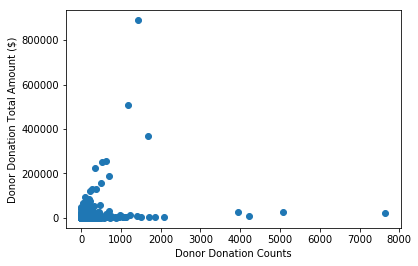

In [19]:
plt.scatter(donors_donation_counts['count'], donors_donation_counts['total_amount'])
plt.xlabel('Donor Donation Counts')
plt.ylabel('Donor Donation Total Amount ($)');

Median Average Donation for each Donation Count Bin

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


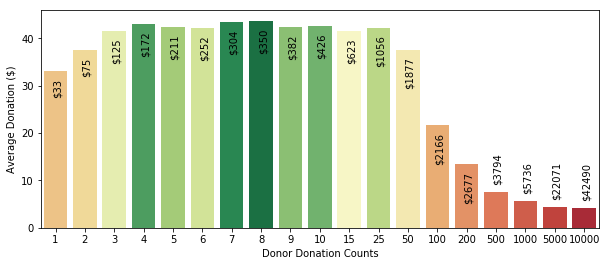

In [20]:
donation_count_avgs = donors_donation_counts.groupby('bin')['avg'].quantile(.5)
plt.subplots(figsize=(10, 4))

values = donation_count_avgs.values

mult = values * donate_freq_bins

pal = sns.color_palette("RdYlGn_r", len(values))
rank = values.argsort().argsort()

sns.barplot(x=donate_freq_bins, y=values, palette=np.array(pal[::-1])[rank])

plt.xlabel('Donor Donation Counts')
plt.ylabel('Average Donation ($)');

for x in range(len(donate_freq_bins)):
    v = donation_count_avgs.values[x]
    
    a='bottom'
    o = 1.5
    
    if v > 12:
        a = 'top'
        o = -1.5        
    plt.text(-0.1+x, donation_count_avgs.values[x] + o, '$'+str(int(mult[x])), rotation=90, va=a)

A donor moving up to the next donation count bin would account for how much of an increase in median average donation?

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


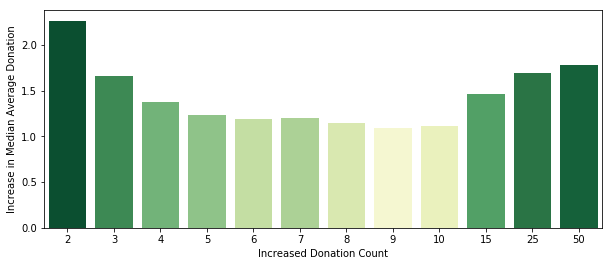

In [21]:
plt.subplots(figsize=(10, 4))
inc = mult[1:] / mult[:-1]

up_to = 12

pal = sns.color_palette("YlGn_r", up_to)
rank = inc[:up_to].argsort().argsort()

sns.barplot(x=donate_freq_bins[1:up_to+1], y=inc[:up_to], palette=np.array(pal[::-1])[rank])
plt.ylabel('Increase in Median Average Donation')
plt.xlabel('Increased Donation Count');

A jump from a one-time donor to a two-time donor is the most significant, reasonable increase. The median average donation is likely to increase more than two-fold.

Which group of frequencies has the highest average donation per donor?

In [23]:
binned = donors_donation_counts.groupby('bin')
freq_described = binned.describe()['avg']
print('Top five donation frequencies by mean average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, 'mean').index])
print(freq_described.nlargest(5, 'mean')['mean'].values)
print('\nTop five donation frequencies by 25% quantile average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, '25%').index])
print(freq_described.nlargest(5, '25%')['25%'].values)
print('\nTop five donation frequencies by 50% quantile average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, '50%').index])
print(freq_described.nlargest(5, '50%')['50%'].values)
print('\nTop five donation frequencies by 75% quantile average donation amount:')
print(donate_freq_bins[freq_described.nlargest(5, '75%').index])
print(freq_described.nlargest(5, '75%')['75%'].values)

Top five donation frequencies by mean average donation amount:
[5000   50   25  100    8]
[ 87.89302151  74.38347853  72.66522506  70.85511394  68.0467961 ]

Top five donation frequencies by 25% quantile average donation amount:
[ 7  8  9 10  6]
[ 29.28571429  28.75        28.33333333  27.7         27.5       ]

Top five donation frequencies by 50% quantile average donation amount:
[ 8  7  4 10  9]
[ 43.75        43.42857143  43.04625     42.6         42.47777778]

Top five donation frequencies by 75% quantile average donation amount:
[ 50 100  25   3   4]
[ 94.90456294  77.44613818  74.94684783  73.33333333  71.515     ]


What kind of outliers exist in the set? Is it reasonable for donors to have given more than 365 times with their average donation exceeding \$5 per donation? 47 donors fall under this category. Do we keep them?

In [24]:
excessive_amount_donors = donors_donation_counts[(donors_donation_counts['avg'] > 5) &
                                                 (donors_donation_counts['count'] > 365)]
print(len(excessive_amount_donors))

47


Do people actually donate \$5,600-25,000 in a single online transaction? Are there actually individuals who have donated a cumulative \$130,000-900,000 over 370-1,400 donations? Are there actually individuals who have donated more than 1,400 times? Are these scenarios realistic, or do they show an underlying pattern that is confounding our perspective on high/frequent donors?

Let's look at high frequency donors. Since 7,651 donations in one year is roughly 21 donations a day, we'd like to make sure that's a realistic looking entry.

In [26]:
high_freq_donor_ids = donors_donation_counts.sort_values('count', ascending=False)[:10].index
total_donations_count = sum(donors_donation_counts.sort_values('count', ascending=False)[:10]['count'])
'Total # of donations for top 10 donors by donation count: {}'.format(total_donations_count)

'Total # of donations for top 10 donors by donation count: 31211'

In [27]:
high_freq_projects = donations_subset[donations_subset['donor_id'].isin(high_freq_donor_ids)].drop_duplicates('project_id')
print('# of unique projects for top 10 donors by donation count: {}'.format(len(high_freq_projects)))

# of unique projects for top 10 donors by donation count: 8378


http://www.ipl.org/div/stateknow/popchart.html

## Geography

### Proportion of unique donors to state population

Null hypothesis: Each state has the same proportion of donors to state population.

If we reject this ($p<0.05$), we have proof that one or more states is significantly different from other states with regards to number of unique donors.

In [28]:
states_pop = pd.read_table('data/statepop.txt', names=['state', 'population'])

In [29]:
donors_subset_donations_inc = donors_subset.merge(donors_donation_counts, left_on='donor_id', right_index=True)
donors_subset_donations_inc = donors_subset_donations_inc[donors_subset_donations_inc['donor_state'] != 'other']

In [30]:
unique_donors_per_state = donors_subset_donations_inc.groupby('donor_state').size()
unique_donors_per_state = pd.DataFrame(unique_donors_per_state, columns=['donors']).reset_index()

p-value: 1.0


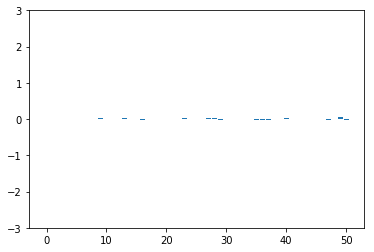

In [31]:
donor_states_pop = states_pop.merge(unique_donors_per_state, right_on='donor_state', left_on='state')
donor_states_pop.loc[:, 'ratio'] = donor_states_pop['donors'] / donor_states_pop['population']

fo = donor_states_pop['ratio']
fe = donor_states_pop['ratio'].mean()
print('p-value: {}'.format(st.chisquare(fo).pvalue))
residuals = (fo-fe)/ np.sqrt(fe)
plt.bar(range(len(residuals)), residuals)

plt.ylim([-3,3]);

We do not reject the null ($p=1.0$). States have no preference for number of donors per.

### Proportion of donation amount per person to states

What about the amount being donated from each state?

In [32]:
total_donated_per_state = donors_subset_donations_inc.groupby('donor_state')['total_amount'].sum()
total_donated_per_state = pd.DataFrame(total_donated_per_state, columns=['total_amount']).reset_index()

p-value: 1.0


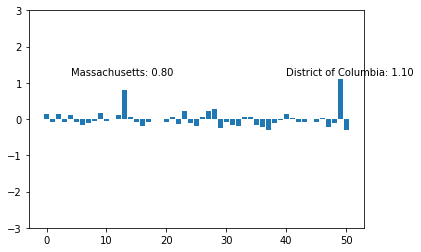

In [33]:
donor_states_amt = states_pop.merge(total_donated_per_state, right_on='donor_state', left_on='state').drop('donor_state', axis=1)
donor_states_amt.loc[:, 'ratio'] = donor_states_amt['total_amount'] / donor_states_amt['population']

fo = donor_states_amt['ratio']
fe = donor_states_amt['ratio'].mean()
print('p-value: {}'.format(st.chisquare(fo).pvalue))
residuals = (fo-fe)/ np.sqrt(fe)
plt.bar(range(len(residuals)), residuals)

plt.ylim([-3,3])

outliers = residuals[np.absolute(residuals) > 0.5].index
for outlier in outliers:
    l = '{}: {:.2f}'.format(donor_states_amt.loc[outlier, 'state'], residuals[outlier])
    plt.annotate(l, xy=(outlier-9, 1.2))

Each state has about the same amount in donations coming from donors, however the amount being donated does vary more than the number of donators per state. In fact, Massachusetts and D.C seem to have more coming from an individuals than other states.

In [ ]:
donor_habits = []
c = 0
completed = []
for donor in donations_subset['donor_id']:
    
    if donor in completed:
        continue
    else:
        completed.append(donor)
        
    donations = donations_subset.loc[donations_subset['donor_id'] == donor, ['project_id', 'amount', 'date']].sort_values('date')
    
    donations_spread = np.median(donations.iloc[1:, 2].values - donations.iloc[:-1, 2].values)
    donations_amount = np.median(donations.iloc[1:, 2].values - donations.iloc[:-1, 2].values)
    
    donor_habits.append([len(donations), 
                         len(np.unique(donations['project_id']))
                         , donations_spread])
    
    if (c+1) % 25 == 0:
        break
    c += 1 
donor_habits = pd.DataFrame(donor_habits, columns=['total_donations', 'total_projects', 'donations_spread'])

People who have donated only twice, with more than a day between donations, without donating more than \$300 in any one donation. Donate only a little the 1st time, donate a lot more the second time = bottom right.

In [34]:
donations_donor_count = donations_subset.groupby('donor_id').size()

i = donations_donor_count[donations_donor_count == 2].index

t = donations_subset[donations_subset['donor_id'].isin(i)].groupby('donor_id')

In [35]:
# 0: 1st donation amount, 1: 2nd donation amount
coupled_donation_amounts = []
ids = []
c = 0
for row in t:
    s_row = row[1].sort_values('date')
    diff = s_row['date'].values[1] - s_row['date'].values[0]
    
    if diff > 60 * 60 * 24:
        
        v = s_row['amount'].values
        if max(v) < 300:
            coupled_donation_amounts.append(v)
            ids.append(row[0])
    
coupled_donation_amounts = np.array(coupled_donation_amounts)
ids = np.array(ids)

Text(0.5,0,'Second Donation')

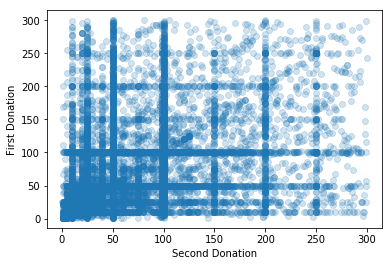

In [36]:
plt.scatter(coupled_donation_amounts[:, 0], coupled_donation_amounts[:, 1], alpha=0.2)
plt.ylabel('First Donation')
plt.xlabel('Second Donation')

In [ ]:
# greater donation the first time
g1_mask = coupled_donation_amounts[:, 0] > coupled_donation_amounts[:, 1]
g1 = coupled_donation_amounts[g1_mask]
g1_ids = ids[g1_mask]
# greater or equal donation the second time
g2_mask = coupled_donation_amounts[:, 1] >= coupled_donation_amounts[:, 0]
g2 = coupled_donation_amounts[g2_mask]
g2_ids = ids[g2_mask]

g2

In [ ]:
g1_states, g1_states_c = np.unique(donors_subset.loc[donors_subset['donor_id'].isin(g1_ids), 'donor_state'], return_counts=True)
g2_states, g2_states_c = np.unique(donors_subset.loc[donors_subset['donor_id'].isin(g2_ids), 'donor_state'], return_counts=True)

Is there a state which gives more the second donation?

In [ ]:
g1_states_c = g1_states_c / sum(g1_states_c)
g1_df = pd.DataFrame({'state': g1_states, 'proportion': g1_states_c, 'cat': [0] * len(g1_states)}).nlargest(10, 'proportion')
g2_states_c = g2_states_c / sum(g2_states_c)
g2_df = pd.DataFrame({'state': g2_states, 'proportion': g2_states_c, 'cat': [1] * len(g1_states)}).nlargest(10, 'proportion')
g_df = pd.concat([g1_df, g2_df], axis=0)

### Political Leanings and Donations

In [37]:
elections_2014 = pd.read_csv('data/data_clean/2014elections_clean.csv', index_col='state')

In [39]:
s = elections_2014.sum(axis=1)
elections_2014['democrat_prob'] = elections_2014['democrat'] / s
elections_2014['republican_prob'] = elections_2014['republican'] / s
elections_2014['third_prob'] = elections_2014['third'] / s

donor_states_politcal = donor_states_amt.merge(elections_2014.drop(['democrat', 'republican', 'third'], axis=1), right_index=True, left_on='state')

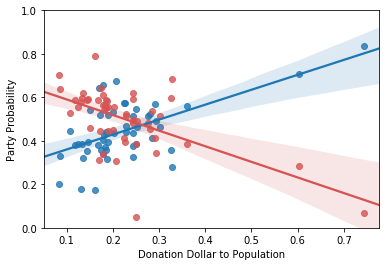

In [40]:
sns.regplot('ratio', 'democrat_prob', data=donor_states_politcal)
sns.regplot('ratio', 'republican_prob', data=donor_states_politcal, color='#D65353')

plt.ylabel('Party Probability')
plt.xlabel('Donation Dollar to Population')
plt.ylim([0,1]);

Correlation with Household Income

In [ ]:
zipcodetaxes = pd.read_csv('data/tax.csv')[['agi_stub', 'zipcode', 'N1', 'A00100', 'N19700', 'A19700']]

In [ ]:
zipcodetaxes[zipcodetaxes['zipcode'] == 92037] #/100).astype('int')

In [ ]:
round(a['A00100'].values.mean()), round(np.average(a['A00100'].values, weights=a['N1'].values))

What do high/frequent donors give to? What do low/infrequent donors give to?

We examine donations with a minimum number of minutes $\beta$ between them, for all donors with exactly $\delta$ number of donations. For $\delta=4$ and $\beta$ ranging from 30 seconds to 60 minutes, we see there is always a decreasing amount of time between donations as the the donation ordinal increases.

In [41]:
dim = 3

a = donations_subset.groupby('donor_id').size()
i = a[a == dim].index

t = donations_subset[donations_subset['donor_id'].isin(i)].groupby('donor_id')

In [42]:
c = 0

gaps = []

for row in t:
    s_row = row[1].sort_values('date')
    diffs = s_row['date'].values[1:] - s_row['date'].values[:-1]
    gaps.append(diffs / (60 * 60 * 24))
    c += 1
    if c % 500 == 0:
        break
gaps = np.array(gaps)

In [43]:
res = []

for threshold in [0.5, 1, 2, 3, 4, 5, 10, 15, 20]:

    for d in range(dim-1):
        res.append([threshold, np.median(gaps[gaps[:, d] >= (threshold/60)]), d])
res = np.array(res)

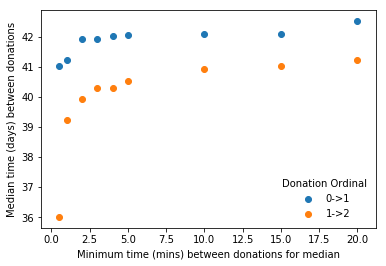

In [44]:
for d in range(dim-1):
    mask = res[:, 2] == d
    plt.scatter(res[mask, 0], res[mask, 1], label='{}->{}'.format(d, d+1))
    
plt.xlabel('Minimum time (mins) between donations for median')
plt.ylabel('Median time (days) between donations')
plt.legend(title='Donation Ordinal', frameon=False);

In [ ]:
amounts = []
for d in range(1, 3):
    a = donations_subset.groupby('donor_id').size()
    i = a[a == d].index

    t = donations_subset[donations_subset['donor_id'].isin(i)].groupby('donor_id')

    print('Donors grouped: {}'.format(d))
    for row in t:
        latest_amount = row[1].sort_values('date', ascending=False).iloc[0, 4]
        amounts.append([d, latest_amount])
        
amounts = np.array(amounts)

In [ ]:
amounts = pd.DataFrame(amounts, columns=['group', 'amount'])
sns.boxplot('group', 'amount', data=amounts[amounts['amount'] < 300])

In [ ]:
a = donations_subset.groupby('donor_id')
b = a.size()

indices = [b[b == donation_count].index for donation_count in range(1,3)]

## Donations by Teachers

Are teachers more likely to give more money? to donate to a wider variety of projects? to have more donations? What is the difference in total amount donated by teachers compared to nonteachers?

# Explore

What are the unique resources a project can be categorized with? From docs:

> **Project Resource Category:** The types of items being requested by a teacher. There were five resource categories prior to October 10, 2017. After this date, there are fourteen. Prior to October 10, 2017, these categories were selected by teachers during project creation. After October 10, 2017, these categories were predicted via algorithm at roughly 95% accuracy.

In [45]:
projects_notext_dat['resource_cat'].unique()

array(['Technology', 'Supplies', 'Books', 'Other', 'Trips', 'Visitors',
       nan, 'Sports & Exercise Equipment', 'Computers & Tablets',
       'Flexible Seating', 'Reading Nooks, Desks & Storage',
       'Educational Kits & Games', 'Instructional Technology',
       'Art Supplies', 'Classroom Basics', 'Lab Equipment',
       'Food, Clothing & Hygiene', 'Musical Instruments'], dtype=object)

What are the unique categories and subcategories a project may be tagged as? From docs:

> **Project Subject Category Tree:** Every project can have either one or two subject categories. This is a comma-separated list of those subject categories.

> **Project Subject Subcategory Tree:** For every project subject category, there is also a project subject subcategory that contains greater specificity.

In [46]:
cats = []
for cat in projects_notext_dat['cat_tree'].unique():
    if type(cat) is str:
        for c in cat.split(', '):
            cats.append(c)
        
np.unique(cats)

array(['Applied Learning', 'Care & Hunger', 'Health & Sports',
       'History & Civics', 'Literacy & Language', 'Math & Science',
       'Music & The Arts', 'Special Needs', 'Warmth'],
      dtype='<U19')

In [47]:
cats = []
for cat in projects_notext_dat['subcat_tree'].unique():
    if type(cat) is str:
        for c in cat.split(', '):
            cats.append(c)
        
np.unique(cats)

array(['Applied Sciences', 'Care & Hunger', 'Character Education',
       'Civics & Government', 'College & Career Prep', 'Community Service',
       'ESL', 'Early Development', 'Economics', 'Environmental Science',
       'Extracurricular', 'Financial Literacy', 'Foreign Languages',
       'Gym & Fitness', 'Health & Life Science', 'Health & Wellness',
       'History & Geography', 'Literacy', 'Literature & Writing',
       'Mathematics', 'Music', 'Nutrition Education', 'Other',
       'Parent Involvement', 'Performing Arts', 'Social Sciences',
       'Special Needs', 'Team Sports', 'Visual Arts', 'Warmth'],
      dtype='<U21')